<a href="https://colab.research.google.com/github/lilian95520/ML-Predicting-university-student-performance/blob/main/Projet_ML_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Project - Laura Aboukrat, Laura Deleuze, Lilian Allio

---



# Introduction

**Our goal : Predicting university student performance**

This project aims to predict students final grades (A, B or C) based on demographic, academic, social and lifestyle factors.

Using machine learning, the goal is to identify which variables strongly influence academic success. By building a predictive model, we can detect students at risk of low performance early and provide targeted academic or psychological support. This analysis can help universities design personalized learning strategies and improve student outcomes.

In [57]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_regression

# Descriptive analysis

### Dataset loading

In [58]:
df = pd.read_csv("Student_performance_data _.csv")
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


### Creation of GradeClass

The initial column **GradeClass** was created by the owner of the dataset based on the GPA score. Five grade categories were defined: A, B, C, D, and F. We decided to rebuild this variable because the dataset contains only 2392 observations and keeping five separate classes would lead to:
- Highly imbalanced categories, especially for A and E
- Too few samples per class, degrading model training
- Lower predictive performance due to class sparsity

To address this issue, we grouped the original five classes into three categories:
- 0: A + B : High performance
- 1: C + D : Medium performance
- 2: E : Low performance

This new version of GradeClass ensures a more balanced distribution and makes the prediction task more realistic for machine learning models given the dataset size.

In [59]:
df = df.drop(columns=['GradeClass', 'StudentID']) #we drop StduentID because it's useless
df.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061


In [60]:
def map_grade(gpa):
    if gpa>=3.0:         #A
        return 0
    elif gpa>=2.0:       #B
        return 1
    else:                #C
        return 2

df['GradeClass']=df['GPA'].apply(map_grade)


### Dataset information

In [61]:
print("Shape of the dataset: ",df.shape)
print("Columns of the dataset: \n",df.columns)

Shape of the dataset:  (2392, 14)
Columns of the dataset: 
 Index(['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly',
       'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports',
       'Music', 'Volunteering', 'GPA', 'GradeClass'],
      dtype='object')


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GPA                2392 non-null   float64
 13  GradeClass         2392 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 261.8 KB


In [63]:
df.isna().any()

,0
Age,False
Gender,False
Ethnicity,False
ParentalEducation,False
StudyTimeWeekly,False
Absences,False
Tutoring,False
ParentalSupport,False
Extracurricular,False
Sports,False


**The dataset contains no missing values:** all columns have complete data. This allows exploratory analysis and model preparation to be carried out without any imputation steps.

In [64]:
df.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,1.398411
std,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,0.712942
min,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,1.000000
50%,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,2.000000
75%,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,2.000000
max,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000


Descriptive statistics show that the dataset is **complete and balanced**. The age of students varies mainly between 15 and 18, with an average of 16.47. Weekly study time varies greatly, ranging from almost 0 to 20 hours. Absences are also widely dispersed, with some reaching nearly 30 days. Several variables are binary (Sports, Tutoring, Extracurricular) while others are ordinal (ParentalEducation, ParentalSupport). The GPA ranges from 0 to 4, with an average of around 1.9, which corresponds to a distribution generally centered on average to low performance. Finally, the grade class (GradeClass) is divided into three categories (0, 1, 2) after grouping.



# Exploratory analysis

In [65]:
categorical_cols = ["Gender", "Ethnicity", "ParentalEducation",
                    "Tutoring", "ParentalSupport", "Extracurricular",
                    "Sports", "Music", "Volunteering", "GradeClass"]

numerical_cols = ["Age", "StudyTimeWeekly", "Absences", "GPA"]

### Distribution of categorical features

In [66]:
#use 2 versions of df: the normal version and a text version for graphs
df_label=df.copy()

mapping_gender={
    0: "Male",
    1: "Female"
}
df_label["Gender"]=df_label["Gender"].map(mapping_gender)

mapping_ethnicity = {
    0: "Caucasian",
    1: "African American",
    2: "Asian",
    3: "Other"
}
df_label["Ethnicity"]=df_label["Ethnicity"].map(mapping_ethnicity)

mapping_parentalEducation={
    0: "None",
    1: "High School",
    2: "Some College",
    3: "Bachelor's",
    4: "Higher"
}
df_label["ParentalEducation"]=df_label["ParentalEducation"].map(mapping_parentalEducation)

mapping_tutoring={
    0: "No",
    1: "Yes"
}
df_label["Tutoring"]=df_label["Tutoring"].map(mapping_tutoring)

mapping_parentalSupport={
    0: "None",
    1: "Low",
    2: "Moderate",
    3: "High",
    4: "Very High"
}
df_label["ParentalSupport"]=df_label["ParentalSupport"].map(mapping_parentalSupport)

mapping_extracurricular={
    0: "No",
    1: "Yes"
}
df_label["Extracurricular"]=df_label["Extracurricular"].map(mapping_extracurricular)

mapping_sports={
    0: "No",
    1: "Yes"
}
df_label["Sports"]=df_label["Sports"].map(mapping_sports)

mapping_music={
    0: "No",
    1: "Yes"
}
df_label["Music"]=df_label["Music"].map(mapping_music)

mapping_volunteering={
    0: "No",
    1: "Yes"
}
df_label["Volunteering"]=df_label["Volunteering"].map(mapping_volunteering)

mapping_gradeClass={
    0: "High",
    1: "Medium",
    2: "Low"
}
df_label["GradeClass"]=df_label["GradeClass"].map(mapping_gradeClass)

In [67]:
for col in categorical_cols:
    #Prepare the dataframe for Plotly
    temp=df_label[col].value_counts().reset_index()
    temp.columns=[col, "Count"]

    #interactive plot
    fig=px.bar(
        temp,
        x=col,
        y="Count",
        text="Count",
        title=f"Distribution of {col}",
        color=col,
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(
        title_x=0.5,
        template="plotly_white",
        xaxis_title="",
        yaxis_title="Count",
        showlegend=False,
        font=dict(size=14))

    fig.show()




- **Gender:** The proportion of **girls** and **boys** is balanced, with no marked imbalance between the two genders

- **Ethnicity:** The majority of students belong to the **Caucasian** ethnic group

- **Parental Education:** Regarding parents' education levels, the **college** category is the most common, followed by high school diplomas, then parents with bachelor's degrees

- **Parental support:** The level of parental support is generally moderate or high

- A large proportion of students do not participate in **music**, **sports**, **tutoring** or **volunteering**

- **GradeClass:** The distribution of grade classes is clearly unbalanced: the majority of students belong to the Low category (1,274 students), while the Medium category is moderately represented (797 students). The High category is clearly in the minority, with only 321 students. This distribution indicates a dataset dominated by low performance, which will need to be taken into account during modeling, particularly to manage class imbalance.








### Distribution of numerical features

In [68]:
import plotly.express as px

for col in numerical_cols:
    fig = px.histogram(
        df_label,
        x=col,
        nbins=20,
        title=f"Distribution of {col}",
        opacity=0.85,
        color_discrete_sequence=["cornflowerblue"]
    )

    # Barres séparées + contour
    fig.update_traces(
        marker=dict(
            line=dict(width=1.2, color="white")  # contour blanc
        )
    )

    # Ajout d’espace entre les colonnes
    fig.update_layout(
        bargap=0.2,           # ← espace net entre les barres
        bargroupgap=0.1,
        template="plotly_white",
        title_x=0.5,
        font=dict(size=14),
        height=500
    )

    fig.show()


- **Age:** The sample has a homogeneous **age** distribution, ranging from 15 to 18 years old, with no group significantly over or under-represented

- **StudTimeWeekly:** Weekly study time is fairly evenly distributed between 0 and 20 hours. There is a slight concentration around 10 to 12 hours, but no category really dominates. This indicates that students adopt very varied study patterns and that there is no majority behavior

- **Absences:** The number of absences varies greatly among students, but the distribution remains relatively even overall. There is a slight peak around 10 to 15 absences, which shows that a significant proportion of students regularly miss classes

- **GPA:** The GPA distribution is centered between 1.5 and 2.5, with a maximum around 2.0. Very few students have a GPA close to 0 or 4. This bell curve suggests overall average academic performance, with few extremes


### Exploring correlations

**Correlation Matrix:**

In [69]:
df_numerical = df_label[numerical_cols]
corr = df_numerical.corr()

fig = px.imshow(
    corr,
    text_auto=".2f",
    color_continuous_scale="RdBu",
    title="Correlation Matrix for numerical features"
)
fig.update_layout(title_x=0.5)
fig.show()



The correlation matrix shows that very few linear relationships exist between the numerical variables, with the exception of one particularly strong relationship.

- **Absences** has a strong negative correlation with **GPA** (-0.92):  
This means that the more a student is absent, the more their GPA decreases significantly. This is the most predictive indicator of academic performance in the dataset.

- **StudyTimeWeekly** has a weak positive correlation with **GPA** (+0.18):
Students who study more tend to perform better, but the effect is small.

- **Age** has virtually no correlation with other variables, including **GPA**:
This suggests that age does not play a significant role in performance.

The matrix highlights that absences are the most decisive variable in explaining academic success, while age and study time play a secondary or negligible role.



**Visualization of possible correlations:**

- Average Absences per Grade

In [70]:
df_mean = df_label.groupby("GradeClass", as_index=False)["Absences"].mean()

fig=px.bar(
    df_mean,
    x="GradeClass",
    y="Absences",
    title="Average Absences per Grade",
    color="Absences",
    color_continuous_scale="Viridis")
fig.update_layout(
    width=700,
    height=500,
    title_x=0.5,
    xaxis_title="Grade",
    yaxis_title="Average Absences")
fig.show()


The graph confirms what we had already noticed: a clear relationship between academic level and the average number of absences.

- **Low-level** students are by far the most absent, with an average of more than 21 absences.
This suggests a strong link between high absenteeism and poor academic performance.

- **Medium-level** students have a significantly lower average number of absences (around 9).
They are less absent than struggling students, but still far behind high-performing students.

- **High-level** students, on the other hand, are the least absent, with an average of around 3 absences.
This reinforces the idea that regular attendance contributes significantly to good results.

The graph shows that **the higher the academic level, the less absent students are**.

This is the strongest relationship in the dataset: absenteeism is a powerful indicator of academic performance.



- Average StudyTimeWeekly per Grade

In [71]:
df_mean = df_label.groupby("GradeClass", as_index=False)["StudyTimeWeekly"].mean()

fig=px.bar(
    df_mean,
    x="GradeClass",
    y="StudyTimeWeekly",
    title="Average StudyTimeWeekly per Grade",
    color="StudyTimeWeekly",
    color_continuous_scale="Viridis")
fig.update_layout(
    width=700,
    height=500,
    title_x=0.5,
    xaxis_title="Grade",
    yaxis_title="Average StudyTimeWeekly")
fig.show()

Students with a **High** grade spend on average slightly more time studying each week than those with a **Medium** or **Low** grade.  

The **Low** category studies the least, while **High** has the highest weekly study time, suggesting a **positive relationship** between study time and performance level.

- Boxplot: GPA based on ParentalSupport

In [72]:
px.box(df_label, x="ParentalSupport", y="GPA", color="ParentalSupport",
       category_orders={
        "ParentalSupport": ["Very High", "High", "Moderate", "Low", "None"]})


There is a general trend: **the higher the parental support, the higher the GPA tends to be.**
Students with **Very High** support have the highest GPA medians and a higher overall distribution, while the **Low** and **None** categories show lower medians.

This suggests that parental support plays **a positive role** in academic success.

- Boxplot: GPA based on Tutoring

In [73]:
px.box(df_label, x="Tutoring", y="GPA", color="Tutoring")

Students receiving tutoring have a **slightly higher GPA** on average, with their median score above that of students without tutoring.
However, the difference remains **moderate**, and the variability of the two groups is fairly similar.

Tutoring therefore appears to have a **positive but limited effect** on academic performance.

- Correlation Matrix (numerical+categorical features)

In [74]:
corr_matrix = df.corr()

fig = px.imshow(
    corr_matrix,
    color_continuous_scale="RdBu_r",
    text_auto=".2f",
    title="Correlation Matrix (Encoded Numerical + Categorical)"
)
fig.update_layout(width=900, height=900)
#Improved legibility of labels
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig.update_yaxes(tickfont=dict(size=10))
fig.show()


**Correlation matrix analysis**

*Principal correlations with GPA*

---

**1. Absences -> GPA : -0.92**
- Extremely strong and negative correlation
- The more classes a student misses, the more their GPA drops
- This is by far the most decisive factor

**2. StudyTimeWeekly -> GPA : +0.18**
- Positive but moderate link
- Working more helps, but it is not the most influential factor

**3. Tutoring -> GPA : +0.19**
- Positive and measurable impact
- Consistent with the box plot: tutored students perform slightly better

**4. ParentalSupport -> GPA : +0.15**
- Positive but weak influence
- Parental support helps, but is not decisive

**5. Volunteering -> GPA : +0.09**
- Minor but slightly positive effect
- May reflect more organized or responsible students

*Relationships between explanatory variables*

---

**1. StudyTimeWeekly and Absences :**-0.15
- Students who study more are slightly less absent
- Consistent but weak relationship

**2. Extracurricular, Sports, Music and GPA :** correlations close to 0
- Extracurricular activities have virtually no impact on academic performance

*Demographic variables*

---

- Age, Gender, Ethnicity : virtually no correlations

*ParentalEducation*

---

- Very weak correlations with GPA and other variables


**Conclusion:**

Most important factors:
- Absences (-0.92)
- Tutoring (+0.19)
- StudyTimeWeekly (+0.18)
- ParentalSupport (+0.15)
- Volunteering (+0.09)




# Pre-Processing

### Verification

We have no missing values in our dataset.

In [75]:
sum(df.duplicated())

0

There are no duplicates.

### Outliers

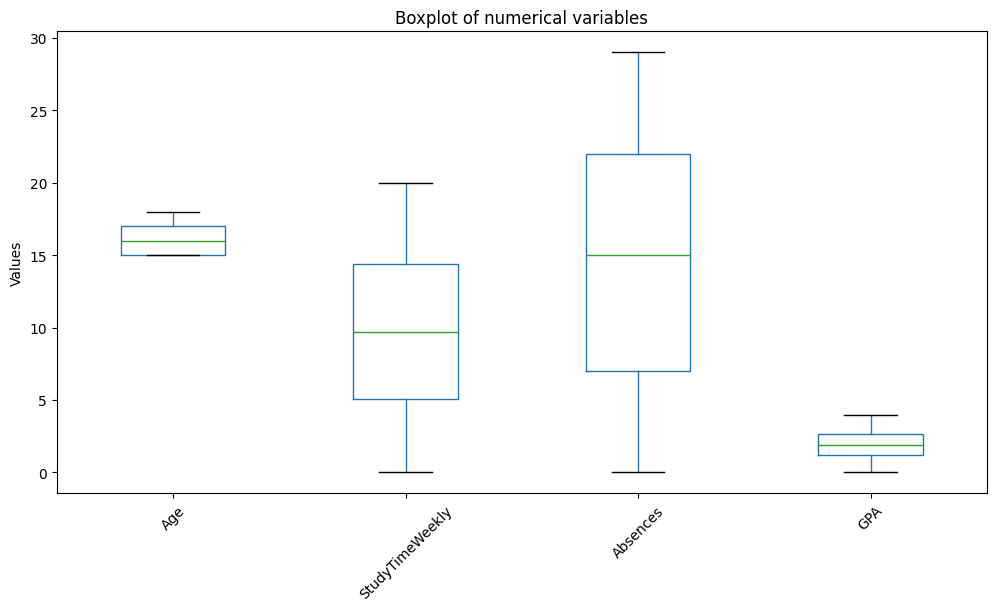

In [76]:
#Creating a box plot to detect outliers
plt.figure(figsize=(12, 6))
df[numerical_cols].boxplot()
plt.title("Boxplot of numerical variables")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

**Boxplot Analysis**

- **Age:** very narrow distribution, no outliers

- **StudyTimeWeekly:** higher variability but no marked outliers

- **Absences:** the most dispersed variable, but ranging from 0 to 29 hours, so no outliers.

- **GPA:** no outliers


### Creation of new features

In [80]:
df["DisciplineScore"]=df["Absences"].max()-df["Absences"]


**DisciplineScore = Absences.max() - Absences**

Why: This variable converts the number of absences into a more intuitive discipline score: the more classes a student misses, the lower their score. It normalizes absences ranging from 0 (least present student) to max (most present student).

It provides a positive scale where:
- A high score = few or no absences, very diligent student
- A low score = many absences, poor discipline, risk of academic difficulties



In [78]:
df["AbsenceStudyRatio"]=df["Absences"]/(df["StudyTimeWeekly"]+1)


**AbsenceStudyRatio = Absences / (StudyTimeWeekly + 1)**

Why:
This feature captures how "costly" the absences are relative to the student's weekly study time. A student who studies very little but has many absences will naturally have a high ratio, indicating a potentially risky academic profile.

It provides an interpretable scale where:
- High ratio : many absences + little studying, high risk of low performance
- Low ratio : few absences or strong study habits, more stable and motivated student

This variable helps quantify whether absences are likely to have a real impact on grades, beyond just counting them.

In [81]:
df["StudySupportInteraction"] = df["StudyTimeWeekly"] * df["ParentalSupport"]


In [79]:
df["SupportScore"] = df["ParentalSupport"] + df["Tutoring"]


In [77]:
df["EngagementScore"] = (
    df["StudyTimeWeekly"]
    + df["Extracurricular"]
    + df["Sports"]
    + df["Music"]
    + df["Volunteering"]
)

In [82]:
# Séparer X et y
X = df.drop(columns=["GPA","GradeClass"])   # <-- mettre ta variable cible ici
y = df["GradeClass"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Importance des variables
importances = rf.feature_importances_
features = X.columns

# On met dans un dataframe
import pandas as pd
fi = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi


,Feature,Importance
15,DisciplineScore,0.357321
5,Absences,0.344987
13,AbsenceStudyRatio,0.107975
16,StudySupportInteraction,0.052201
14,SupportScore,0.031202
12,EngagementScore,0.022010
4,StudyTimeWeekly,0.019098
9,Sports,0.011565
6,Tutoring,0.009486
3,ParentalEducation,0.008240


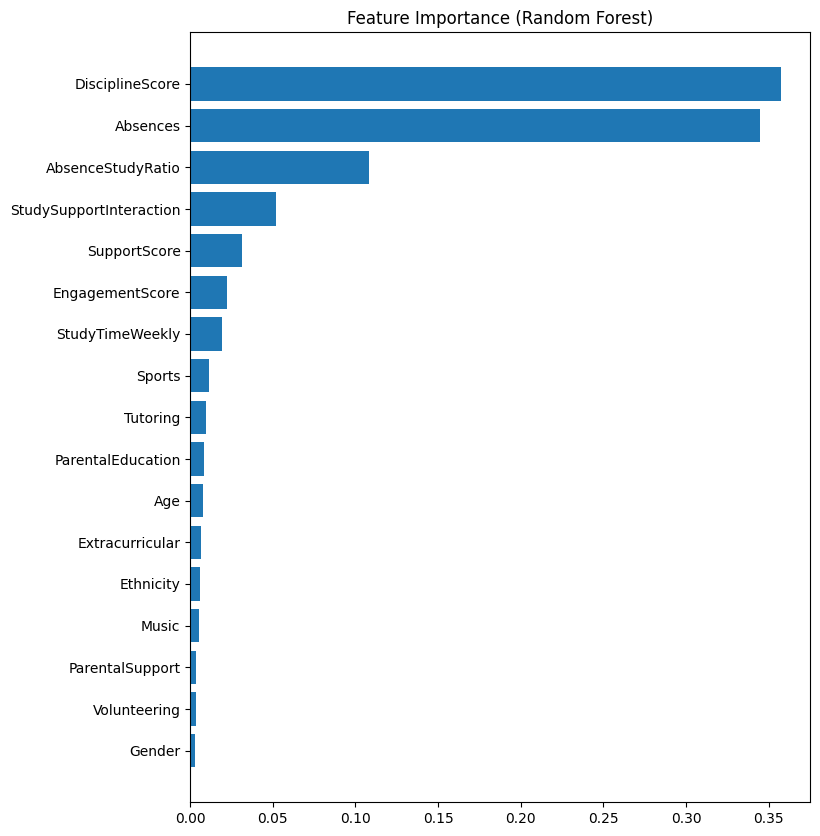

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))
plt.barh(fi["Feature"], fi["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.show()


# Implementation of a baseline model

In [84]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=b3c26524324dd4840057b61433362034cbcf6c3e310aadf1b1886506456bb978
  Stored in directory: /root/.cache/pip/wheels/80/3e/3b/13f1adf346cad0fec675db328e4b0d814795c6c8e2fb659122
Successfully built mord


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mord import OrdinalRidge   #Ordinal Logistic Regression
from xgboost import XGBClassifier


y = df["GradeClass"]
X = df.drop(columns=['GPA','GradeClass'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Ordinal Logistic Regression": OrdinalRidge(alpha=1.0),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        enable_categorical=False)}

# Entraînement + Évaluation

results = []

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    results.append([name, acc])

    print("\n==============================")
    print(name)
    print("==============================")
    print("Accuracy :", acc)
    print("Report :")
    print(classification_report(y_test, preds))

df_results = pd.DataFrame(results, columns=["Modèle", "Accuracy"])
df_results = df_results.sort_values("Accuracy", ascending=False)
print("\n=== Résultats finaux ===")
print(df_results)


Random Forest
Accuracy : 0.8746518105849582
Report :
              precision    recall  f1-score   support

           0       0.87      0.70      0.77        96
           1       0.78      0.87      0.82       239
           2       0.94      0.92      0.93       383

    accuracy                           0.87       718
   macro avg       0.86      0.83      0.84       718
weighted avg       0.88      0.87      0.87       718


Gradient Boosting
Accuracy : 0.883008356545961
Report :
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        96
           1       0.80      0.86      0.83       239
           2       0.95      0.93      0.94       383

    accuracy                           0.88       718
   macro avg       0.86      0.84      0.85       718
weighted avg       0.88      0.88      0.88       718


Ordinal Logistic Regression
Accuracy : 0.8467966573816156
Report :
              precision    recall  f1-score   support

    